# N$_2$H+ cloud grouping

We found that we can fit up to 2 components in N$_2$H+ (1-0) emission. Now we need to assign them.

In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import os
import sys
sys.path.append('../')
from setup import *
from skimage import morphology
%matplotlib widget

In [2]:
params1g, header1g = fits.getdata('../bayes_frame/nested-sampling/NGC1333-SE-mle-x1_filtered.fits', header=True)
params2g, header2g = fits.getdata('../bayes_frame/nested-sampling/NGC1333-SE-mle-x2_filtered.fits', header=True)
npeaks = fits.getdata('../bayes_frame/nested-sampling/npeaks_cut5_noislands.fits')
wcssky = WCS(header1g).celestial

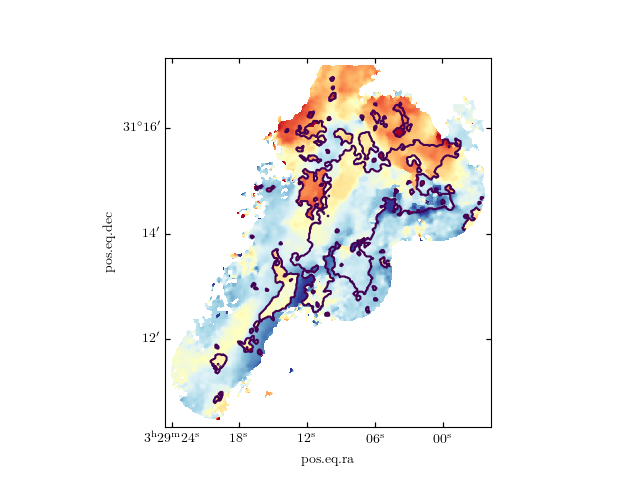

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcssky)

ax.imshow(params1g[1], vmin=7, vmax=9, cmap='RdYlBu_r', interpolation='nearest')
ax.imshow(params2g[4], vmin=7, vmax=9, cmap='RdYlBu_r', interpolation='nearest')
ax.contour(npeaks, levels=[1.5])

We can label the Groups in 1 component fit that are separate from each other

In [6]:
mask1g = np.where(~np.isnan(params1g[0]), 1, 0)
mask2g = np.where(~np.isnan(params2g[0]), 1, 0)
labelmap, labelnum = morphology.label(mask1g, return_num=True)
labellist = [labelmap.flatten().tolist().count(i) for i in range(labelnum)]
labellist.pop(0) # the first label is background
labelmap = labelmap.astype(float)
labelmap[np.where(labelmap==0)] = np.nan
group1 = np.argmax(labellist)+1
labellist[np.argmax(labellist)] = 1
group2 = np.argmax(labellist)+1

#the labels of the leftmost and rightmost groups are 1 and 6, respectively

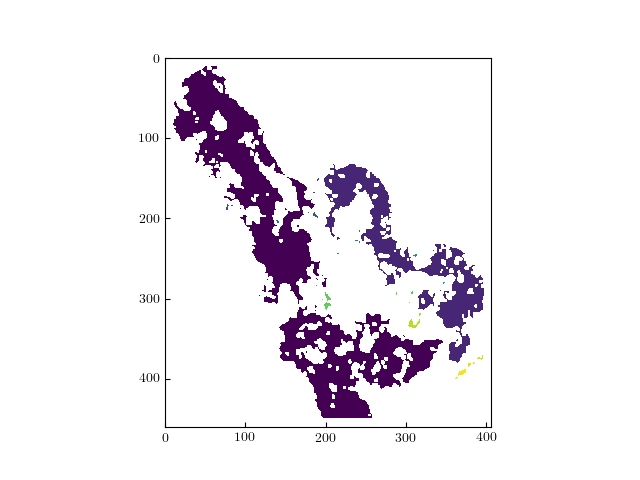

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111) #, projection=wcssky)
showmap = labelmap#np.where(labelmap==group2, 1, 0)
ax.imshow(showmap, cmap='viridis')

In [8]:
xarray = np.linspace(0, header1g['NAXIS1']-1, header1g['NAXIS1'])
yarray = np.linspace(0, header1g['NAXIS2']-1, header1g['NAXIS2'])
xmax = header1g['NAXIS1']-1
ymax = header1g['NAXIS2']-1
#create an array of parameters

paramsgroup1 = np.zeros(np.shape(params1g)) * np.nan
# mask_group1 = np.where(labelmap==group1, 1, 0)

# we first fill the members of the group with 1 Gaussian fit results 
index_group1 = np.where(mask1g) #np.where(labelmap==group1)
for x, y in zip(index_group1[1], index_group1[0]):
    for i in range(6):
            paramsgroup1[i, y, x] = params1g[i, y, x]
            
evaluated = np.zeros(np.shape(npeaks)).astype(int)
evaluated[index_group1] = 1
# paramsgroup2 = np.zeros(np.shape(params1g))
# mask_group2 = np.where(labelmap==group2, 1, 0)

# use the weighted parameter distance from Choudhury et al in prep to assign the values

def weighted_distance(velmap, Tmap, weight, velbase, Tbase):
    deltav = velmap - velbase
    deltaT = Tmap - Tbase
    dp = np.sqrt((weight * deltav)**2 + ((1-weight) * deltaT)**2)
    return dp

def distance_pix(x, y, x0, y0):
    return np.sqrt((x-x0)**2 + (y-y0)**2)

def distance_2G(pixx, pixy, weight, velbase, Tbase):
    vel1 = params2g[1, pixy, pixx]
    T1 = params2g[0, pixy, pixx]
    vel2 = params2g[4, pixy, pixx]
    T2 = params2g[3, pixy, pixx]
    d1 = weighted_distance(vel1, T1, weight, velbase, Tbase)
    d2 = weighted_distance(vel2, T2, weight, velbase, Tbase)
    return d1, d2

def available_neighbors(xx, yy):
    #considering border cases
    
    if xx==0: neighbors_x = [xx+1]
    elif xx==xmax: neighbors_x = [xx-1]
    else: neighbors_x = [xx-1, xx+1]
    
    if yy==0: neighbors_y = [yy+1]
    elif yy==ymax: neighbors_y = [yy-1]
    else: neighbors_y = [yy-1]
    
    # we get all possible combinations of x, y
    combos = np.array(np.meshgrid(neighbors_x, neighbors_y)).T.reshape(-1,2)
    return combos

def get_average_neighbors(xx, yy):
    # border cases
    combos = available_neighbors(xx, yy)
    vel = []
    Tb = []
    for combo in combos:
        vel.append(paramsgroup1[1, combo[1], combo[0]])
        Tb.append(paramsgroup1[0, combo[1], combo[0]])
    
    #normal case
    velbase = np.nanmean(vel)
    Tbase = np.nanmean(Tb)
    return velbase, Tbase
    
def evaluate_distance_neighbors(pixx, pixy, weight):
    velbase, Tbase = get_average_neighbors(pixx, pixy)
    d1, d2 = distance_2G(pixx, pixy, weight, velbase, Tbase)
    if d1 < d2:
        return 0
    else:
        return 3
    
def fill_param_pix_2comp(pixx, pixy, component):
    evaluated[pixy, pixx] = 1
    for i in range(3):
        paramsgroup1[i, pixy,pixx] = params2g[i+component, pixy,pixx] #params
        paramsgroup1[i+3, pixy,pixx] = params2g[i+6+component, pixy,pixx] #errors

In [9]:
x0 = 179
y0 = 244
wei = 0.8 # more to vel than T
xx, yy = np.meshgrid(xarray, yarray)
distancematrix = distance_pix(xx, yy, x0, y0)

df_aux = pd.DataFrame(data=np.transpose([xx.flatten(), yy.flatten(), distancematrix.flatten(), mask2g.flatten()]), columns=['x', 'y', 'distance', '2g'])
df_aux = df_aux[df_aux['2g']==1]
df_aux = df_aux.sort_values('distance', ignore_index=True)


In [10]:
for x, y in zip(df_aux['x'].values.astype(int), df_aux['y'].values.astype(int)):
    if evaluated[y,x]: continue
    elif npeaks[y, x]==1: 
        print('this should not happen')
        continue 
    else:
        index_selected = evaluate_distance_neighbors(x, y, wei)
        fill_param_pix_2comp(x, y, index_selected)
        

/tmp/ipykernel_11713/1142480856.py:65: RuntimeWarning: Mean of empty slice
  velbase = np.nanmean(vel)
/tmp/ipykernel_11713/1142480856.py:66: RuntimeWarning: Mean of empty slice
  Tbase = np.nanmean(Tb)


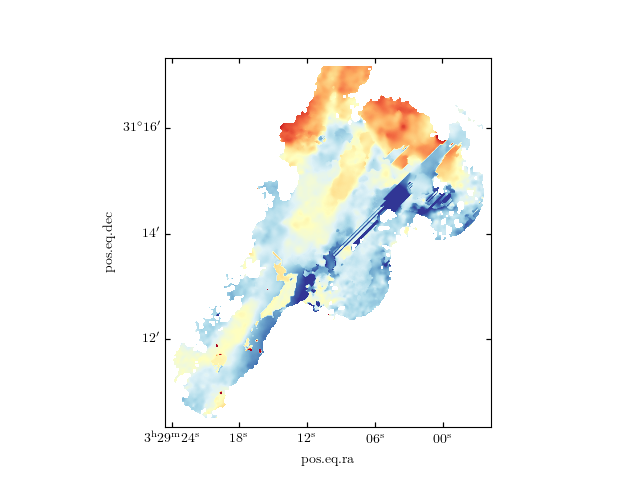

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcssky)
showmap = paramsgroup1[1]
ax.imshow(showmap, vmin=7, vmax=9, cmap='RdYlBu_r') #I think we will have to make it with the groups

In [12]:
# fits.writeto('group1_test.fits', paramsgroup1, header1g, overwrite=True)